In [10]:
from gae import *
import os
os.environ['CUDA_VISIBLE_DEVICES']="1,2,3"

import torch
import networkx as nx

from dataclasses import dataclass, field
from typing import Optional
from accelerate import Accelerator
from datasets import load_dataset, Dataset
from peft import LoraConfig
from tqdm import tqdm
from transformers import (
    Adafactor,
    AutoTokenizer,
    LlamaTokenizer,
    HfArgumentParser,
    pipeline
)
import pandas as pd
import numpy as np
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed
from trl.core import LengthSampler

from MyPPOTrainer import *
from MyLoraConfig import *

In [2]:
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"

tqdm.pandas()

@dataclass
class ScriptArguments:
    """
    The name of the Casual LM model we wish to fine with PPO
    """

    # NOTE: gpt2 models use Conv1D instead of Linear layers which are not yet supported in 8 bit mode
    # models like gpt-neo* models are more suitable.
    model_name: Optional[str] = field(default="NousResearch/Llama-2-7b-chat-hf", metadata={"help": "the model name"})
    tokenizer_name: Optional[str] = field(default="", metadata={"help": "the tokenizer name"})
    reward_model_name: Optional[str] = field(default="lvwerra/distilbert-imdb", metadata={"help": "the reward model name"})
    dataset_name: Optional[str] = field(default="", metadata={"help": "the dataset name"})
    log_with: Optional[str] = field(default="wandb", metadata={"help": "use 'wandb' to log with wandb"})
    learning_rate: Optional[float] = field(default=1.41e-5, metadata={"help": "the learning rate"})
    max_length: Optional[int] = field(default=512, metadata={"help": "maximum length for input"})
    output_max_length: Optional[int] = field(default=128, metadata={"help": "maximum length for generation"})
    mini_batch_size: Optional[int] = field(default=1, metadata={"help": "the PPO minibatch size"})
    batch_size: Optional[int] = field(default=8, metadata={"help": "the batch size"})
    ppo_epochs: Optional[int] = field(default=1, metadata={"help": "the number of ppo epochs"})
    gradient_accumulation_steps: Optional[int] = field(
        default=4, metadata={"help": "the number of gradient accumulation steps"}
    )
    adafactor: Optional[bool] = field(default=False, metadata={"help": "whether to use the adafactor optimizer"})
    early_stopping: Optional[bool] = field(default=True, metadata={"help": "whether to early stop"})
    target_kl: Optional[float] = field(default=0.1, metadata={"help": "kl target for early stopping"})
    reward_baseline: Optional[float] = field(
        default=0.0,
        metadata={"help": "a baseline value that is subtracted from the reward"},
    )
    batched_gen: Optional[bool] = field(default=False, metadata={"help": "whether to use the batched text gen"})
    save_freq: Optional[int] = field(default=None, metadata={"help": "n steps to save the model"})
    output_dir: Optional[str] = field(default="/mnt/nas/coppolillo/LLMs/ppo_checkpoints/",
                                      metadata={"help": "n steps to save the model"})
    seed: Optional[int] = field(default=0, metadata={"help": "the seed"})


#parser = HfArgumentParser(ScriptArguments)
#script_args: ScriptArguments = parser.parse_args_into_dataclasses()[0]
parser = HfArgumentParser((ScriptArguments,))
script_args = parser.parse_args_into_dataclasses(return_remaining_strings=True)[0]
set_seed(script_args.seed)


In [3]:
# Propagation Model

import os, sys
sys.path.insert(0, "../src/")

from data_component import DataComponent
from information_diffusion_component import BoundedConfidenceDiffusionComponent

# synthetic data generator params
num_nodes = 100
modularity = 0.5
homophily = 0.5

# bounded confidence model params
epsilon = 0.2
mu = 0.5

llm_node_id = 0

data = DataComponent(num_nodes, modularity, homophily)
data.pre_compute_neighboring()  # save neighbors for each node

Opinions stats 
mean: 0.43409650762652613
std: 0.2531177104552777
min: 0.004124513320711887
max: 0.9853385079483


Text(0, 0.5, 'occurrences')

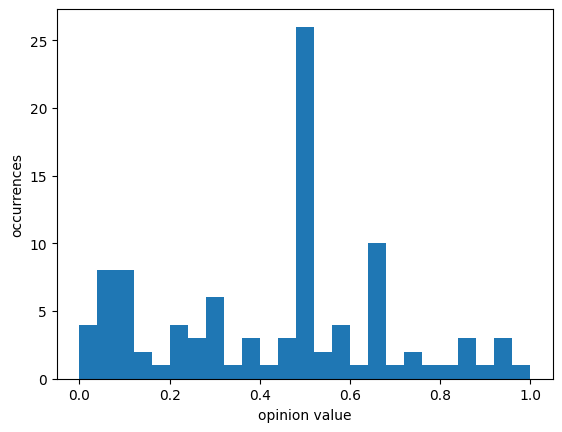

In [4]:
information_diffusion_model = BoundedConfidenceDiffusionComponent(data_component=data, epsilon=epsilon, mu=mu)

opinions = information_diffusion_model.get_opinions()
print(f'Opinions stats \nmean: {opinions.mean()}\nstd: {opinions.std()}\nmin: {opinions.min()}\nmax: {opinions.max()}')

import matplotlib.pyplot as plt
_ = plt.hist(opinions, bins=25, range=[0,1])
plt.xlabel('opinion value')
plt.ylabel('occurrences')

In [11]:
attrs = {}
for n in data.G.nodes():
    attrs.update({n: {"y": n, "x": [opinions[n]]}})
nx.set_node_attributes(data.G, attrs)

In [12]:
# Below is an example function to build the dataset. In our case, we use the IMDB dataset
# from the `datasets` library. One should customize this function to train the model on
# its own dataset.
def build_dataset(
        tokenizer, dataset_name, input_min_text_length=2, input_max_text_length=8
):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """

    #train_dataset = load_dataset(dataset_name, split="train")
    
    prompt = "Generate a post about cats." 
    
    size = 10000
    df = pd.DataFrame(np.repeat(prompt, size), columns=["0"])
    ds = Dataset.from_dict(df)
    
    train_dataset = ds.rename_columns({"0": "question"})
    
    original_columns = train_dataset.column_names
    num_proc = 24

    def preprocess_function(examples):
        new_examples = {
            "query": [],
            "input_ids": [],
        }
        for question in examples["question"]:
            query = "Question: " + question + "\n\nAnswer: \n"
            tokenized_question = tokenizer(query, truncation=True, max_length=script_args.max_length)
            new_examples["query"].append(query)
            new_examples["input_ids"].append(tokenized_question["input_ids"])

        return new_examples

    ds = train_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_proc,
        remove_columns=original_columns,
    )
    ds = ds.filter(lambda x: len(x["input_ids"]) <= script_args.max_length, batched=False)

    ds.set_format(type="torch")
    return ds


def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])


reward_model_name = script_args.reward_model_name
config = PPOConfig(
    model_name=script_args.model_name,
    learning_rate=script_args.learning_rate,
    log_with=script_args.log_with,
    batch_size=script_args.batch_size,
    mini_batch_size=script_args.mini_batch_size,
    gradient_accumulation_steps=script_args.gradient_accumulation_steps,
    optimize_cuda_cache=True,
    early_stopping=script_args.early_stopping,
    target_kl=script_args.target_kl,
    ppo_epochs=script_args.ppo_epochs,
    seed=script_args.seed
)

# We then define the arguments to pass to the sentiment analysis pipeline.
# We set `return_all_scores` to True to get the sentiment score for each token.
rw_kwargs = {
    "return_all_scores": True,
    "function_to_apply": "none",
    "batch_size": script_args.batch_size,
    "truncation": True
}

if "decapoda" in script_args.model_name.lower():
    tokenizer = LlamaTokenizer.from_pretrained(script_args.model_name)
    # required for llama
    tokenizer.add_special_tokens(
        {
            "eos_token": DEFAULT_EOS_TOKEN,
            "bos_token": DEFAULT_BOS_TOKEN,
            "unk_token": DEFAULT_UNK_TOKEN,
            "pad_token": DEFAULT_PAD_TOKEN,
        }
    )
else:
    tokenizer = AutoTokenizer.from_pretrained(script_args.model_name)
    if getattr(tokenizer, "pad_token", None) is None:
        tokenizer.pad_token = tokenizer.eos_token

# We retrieve the dataloader by calling the `build_dataset` function.
dataset = build_dataset(tokenizer, script_args.dataset_name)

Map (num_proc=24):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [13]:
dataset

Dataset({
    features: ['query', 'input_ids'],
    num_rows: 10000
})

In [14]:
config.model_name

'NousResearch/Llama-2-7b-chat-hf'

In [15]:
# Now let's build the model, the reference model, and the tokenizer.
# current_device = Accelerator().local_process_index

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = AutoModelForCausalLMWithValueHead.from_pretrained(
    config.model_name,
    load_in_8bit=False,
    device_map="auto",
    peft_config=lora_config
)

optimizer = None
if script_args.adafactor:
    optimizer = Adafactor(
        filter(lambda p: p.requires_grad, model.parameters()),
        scale_parameter=False,
        relative_step=False,
        warmup_init=False,
        lr=config.learning_rate,
    )

# We then build the PPOTrainer, passing the model, the reference model, the tokenizer
ppo_trainer = PPOTrainer(
    config,
    model,
    ref_model=None,
    tokenizer=tokenizer,
    dataset=dataset,
    data_collator=collator,
    optimizer=optimizer
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/coppolillo/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/coppolillo/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/coppolillo/venv/lib/python3.10/site-packages/tra

In [16]:
config

PPOConfig(exp_name='ipykernel_launcher', seed=0, log_with='wandb', task_name=None, model_name='NousResearch/Llama-2-7b-chat-hf', query_dataset='imdb', reward_model='sentiment-analysis:lvwerra/distilbert-imdb', remove_unused_columns=True, tracker_kwargs={}, accelerator_kwargs={}, project_kwargs={}, tracker_project_name='trl', push_to_hub_if_best_kwargs={}, steps=20000, learning_rate=1.41e-05, adap_kl_ctrl=True, init_kl_coef=0.2, kl_penalty='kl', target=6, horizon=10000, gamma=1, lam=0.95, cliprange=0.2, cliprange_value=0.2, vf_coef=0.1, batch_size=8, forward_batch_size=None, mini_batch_size=1, gradient_accumulation_steps=4, world_size=1, ppo_epochs=1, max_grad_norm=None, optimize_cuda_cache=True, optimize_device_cache=False, early_stopping=True, target_kl=0.1, compare_steps=1, ratio_threshold=10.0, use_score_scaling=False, use_score_norm=False, score_clip=None, whiten_rewards=False, is_encoder_decoder=False, is_peft_model=True, backward_batch_size=4, global_backward_batch_size=4, global

In [17]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a ` pipeline` bug

In [18]:
TRAIN = True

output_min_length = 32
output_max_length = script_args.output_max_length
output_length_sampler = LengthSampler(output_min_length, output_max_length)

In [19]:
sentiment_model = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb")

In [ ]:
if TRAIN:

    # We then build the sentiment analysis pipeline, passing the model name and the
    # sentiment analysis pipeline arguments. Let's also make sure to set the device
    # to the same device as the PPOTrainer.

    # reward_model = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb")

    # We then define the arguments to pass to the `generate` function. These arguments
    # are passed to the `generate` function of the PPOTrainer, which is a wrapper around
    # the `generate` function of the trained model.
    generation_kwargs = {
        # "min_length": -1,
        "top_k": 0.0,
        "top_p": 1.0,
        "do_sample": True,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": 100_000
    }
   

    for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader), total=len(ppo_trainer.dataloader)):
        question_tensors = batch["input_ids"]

        response_tensors = ppo_trainer.generate(
            question_tensors,
            return_prompt=False,
            length_sampler=output_length_sampler,
            **generation_kwargs,
        )
        batch["response"] = tokenizer.batch_decode(response_tensors, skip_special_tokens=True)

        # Compute sentiment score
        texts = [q + r for q, r in zip(batch["query"], batch["response"])]
        sentiment_outputs = sentiment_model(texts, **rw_kwargs)
        # rewards = [torch.tensor(output[0]["score"] - script_args.reward_baseline) for output in reward_outputs]

        messages_values = [output[1]["score"] for output in sentiment_outputs]

        rewards = []
        for message_value in messages_values:
            opinion_shift_tot, num_activated_users, _ = information_diffusion_model.propagate_message(message=message_value,
                                                                                          node_id=llm_node_id)
            rewards.append(torch.tensor(num_activated_users, dtype=torch.float))


        # Run PPO step
        stats = ppo_trainer.step(question_tensors, response_tensors, rewards)
        ppo_trainer.log_stats(stats, batch, rewards)

  0%|                                                                                                                                                                                                          | 0/1250 [00:00<?, ?it/s]You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/coppolillo/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
  0%|▉                                                                                                                                                                                              | 6/1250 [06:51<22:35:24, 65.37s/it]

In [ ]:
saving_path = script_args.output_dir + "llama2-sentiment-propagation"

In [ ]:
if not os.path.exists(saving_path):
    os.makedirs(saving_path)

model.save_pretrained(saving_path)
tokenizer.save_pretrained(saving_path)

In [ ]:
script_args.model_name

In [ ]:
device_ref_model = "cuda:0"
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(script_args.model_name, device_map=device_ref_model)

In [ ]:
LOAD = False  # 

if LOAD:
    device_model = "auto"
            
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        saving_path,
        device_map=device_model
    )
    
    tokenizer = AutoTokenizer.from_pretrained(saving_path)
    
    tokenizer.pad_token = tokenizer.eos_token
    
    ppo_trainer = PPOTrainer(config, model, None, tokenizer)

In [ ]:
list(ref_model.parameters())==list(model.parameters())

In [ ]:
#### get a batch from the dataset
bs = 16
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

In [ ]:
response_tensors_ref = [] 

gen_kwargs = {"min_length": -1, "top_k": 0.0, "top_p": 1.0, "do_sample": True, 
              "pad_token_id": tokenizer.eos_token_id}

for i in range(bs):
    gen_len = output_length_sampler()
    output = ref_model.generate(
        torch.tensor(query_tensors[i], device=device_ref_model).unsqueeze(dim=0), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)

In [ ]:
response_tensors = []

for i in range(bs):
    output = ppo_trainer.generate(
    torch.tensor(query_tensors[i]), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

In [ ]:
#### decode responses
game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
game_data["response (after)"] = [tokenizer.decode(response_tensors[i]) for i in range(bs)]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
# game_data["rewards (before)"] = [output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)] # [output for output in calc_rewards(texts)] # 
game_data_sentiments = [output[1]["score"] for output in sentiment_model(texts, **rw_kwargs)] # [output for output in calc_rewards(texts)] # 
game_data["rewards (before)"] = [information_diffusion_model.propagate_message(message=x,
                                  node_id=llm_node_id)[1] for x in game_data_sentiments] # [output for output in calc_rewards(texts)] # 


texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
#game_data["rewards (after)"] = [output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)] # [output for output in calc_rewards(texts)] # 
game_data_sentiments = [output[1]["score"] for output in sentiment_model(texts, **rw_kwargs)] # [output for output in calc_rewards(texts)] # 
game_data["rewards (after)"] = [information_diffusion_model.propagate_message(message=x,
                                  node_id=llm_node_id)[1] for x in game_data_sentiments]

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

Looking at the reward mean/median of the generated sequences we observe a significant difference.

In [ ]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

In [ ]:
game_data["response (after)"]